In [25]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator, Aer
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.quantum_info import Pauli
import matplotlib.pyplot as plt
from ldpc import BpOsdDecoder
from sympy import Matrix, GF

In [40]:
def rand_bin_array(K, N):
    """
    Generate a random binary array of length N with K ones.
    """
    arr = np.zeros(N, dtype=int)
    arr[:K] = 1
    np.random.shuffle(arr)
    return arr

def cyclic_shift_matrix(arr):
    """
    Generate a cyclic shift matrix from an array.
    """
    N = len(arr)
    matrix = np.zeros((N, N), dtype=int)
    for i in range(N):
        matrix[i] = np.roll(arr, i)
    return matrix

def generate_unicycle_ldpc(m, n):
    """
    Generate a unicycle LDPC code.
    Parameters:
        m: Number of rows (check bits).
        n: Number of columns (code bits).
    Returns:
        Hx, Hz: LDPC parity-check matrices for X and Z errors.
    """
    H = np.random.randint(0, 2, (m, n))
    Hx = H
    Hz = H[:, ::-1]  # Reverse the columns for unicycle codes
    return Hx, Hz

def generate_bicycle_ldpc_1(n, m, k):
    n_sub = int(n/2)
    row = rand_bin_array(k, n_sub)
    c = cyclic_shift_matrix(row)
    return np.concatenate((c, c.T), axis=1)

# USE BICYCLE PARITY CHECK MATRICES
Hx = generate_bicycle_ldpc_1(10, 3, 2)
Hz = Hx

In [41]:
# Verify self-orthogonality
orthogonality_check = np.mod(Hx @ Hz.T, 2)
print("Orthogonality check (should be zero matrix):")
print(orthogonality_check)

Orthogonality check (should be zero matrix):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [34]:
# Construct zeros matrix
zeros = np.zeros(Hx.shape, dtype=int)

# Construct H0 in standard CSS form
H0 = np.block([
    [Hx, zeros],
    [zeros, Hz]
])

In [35]:
def get_stabilizers(H_sub, pauli_char):
    """
    Generate stabilizer strings from a parity-check matrix.
    """
    stabilizers = []
    for row in H_sub:
        stabilizer = ''
        for bit in row:
            stabilizer += pauli_char if bit else 'I'
        stabilizers.append(stabilizer)
    return stabilizers

# Get stabilizers
x_stabilizers = get_stabilizers(Hx, 'X')
z_stabilizers = get_stabilizers(Hz, 'Z')

# Print stabilizers
print("X Stabilizers:")
for stab in x_stabilizers:
    print(stab)

print("\nZ Stabilizers:")
for stab in z_stabilizers:
    print(stab)


X Stabilizers:
IIXXIIIXXI
IIIXXIIIXX
XIIIXXIIIX
XXIIIXXIII
IXXIIIXXII

Z Stabilizers:
IIZZIIIZZI
IIIZZIIIZZ
ZIIIZZIIIZ
ZZIIIZZIII
IZZIIIZZII


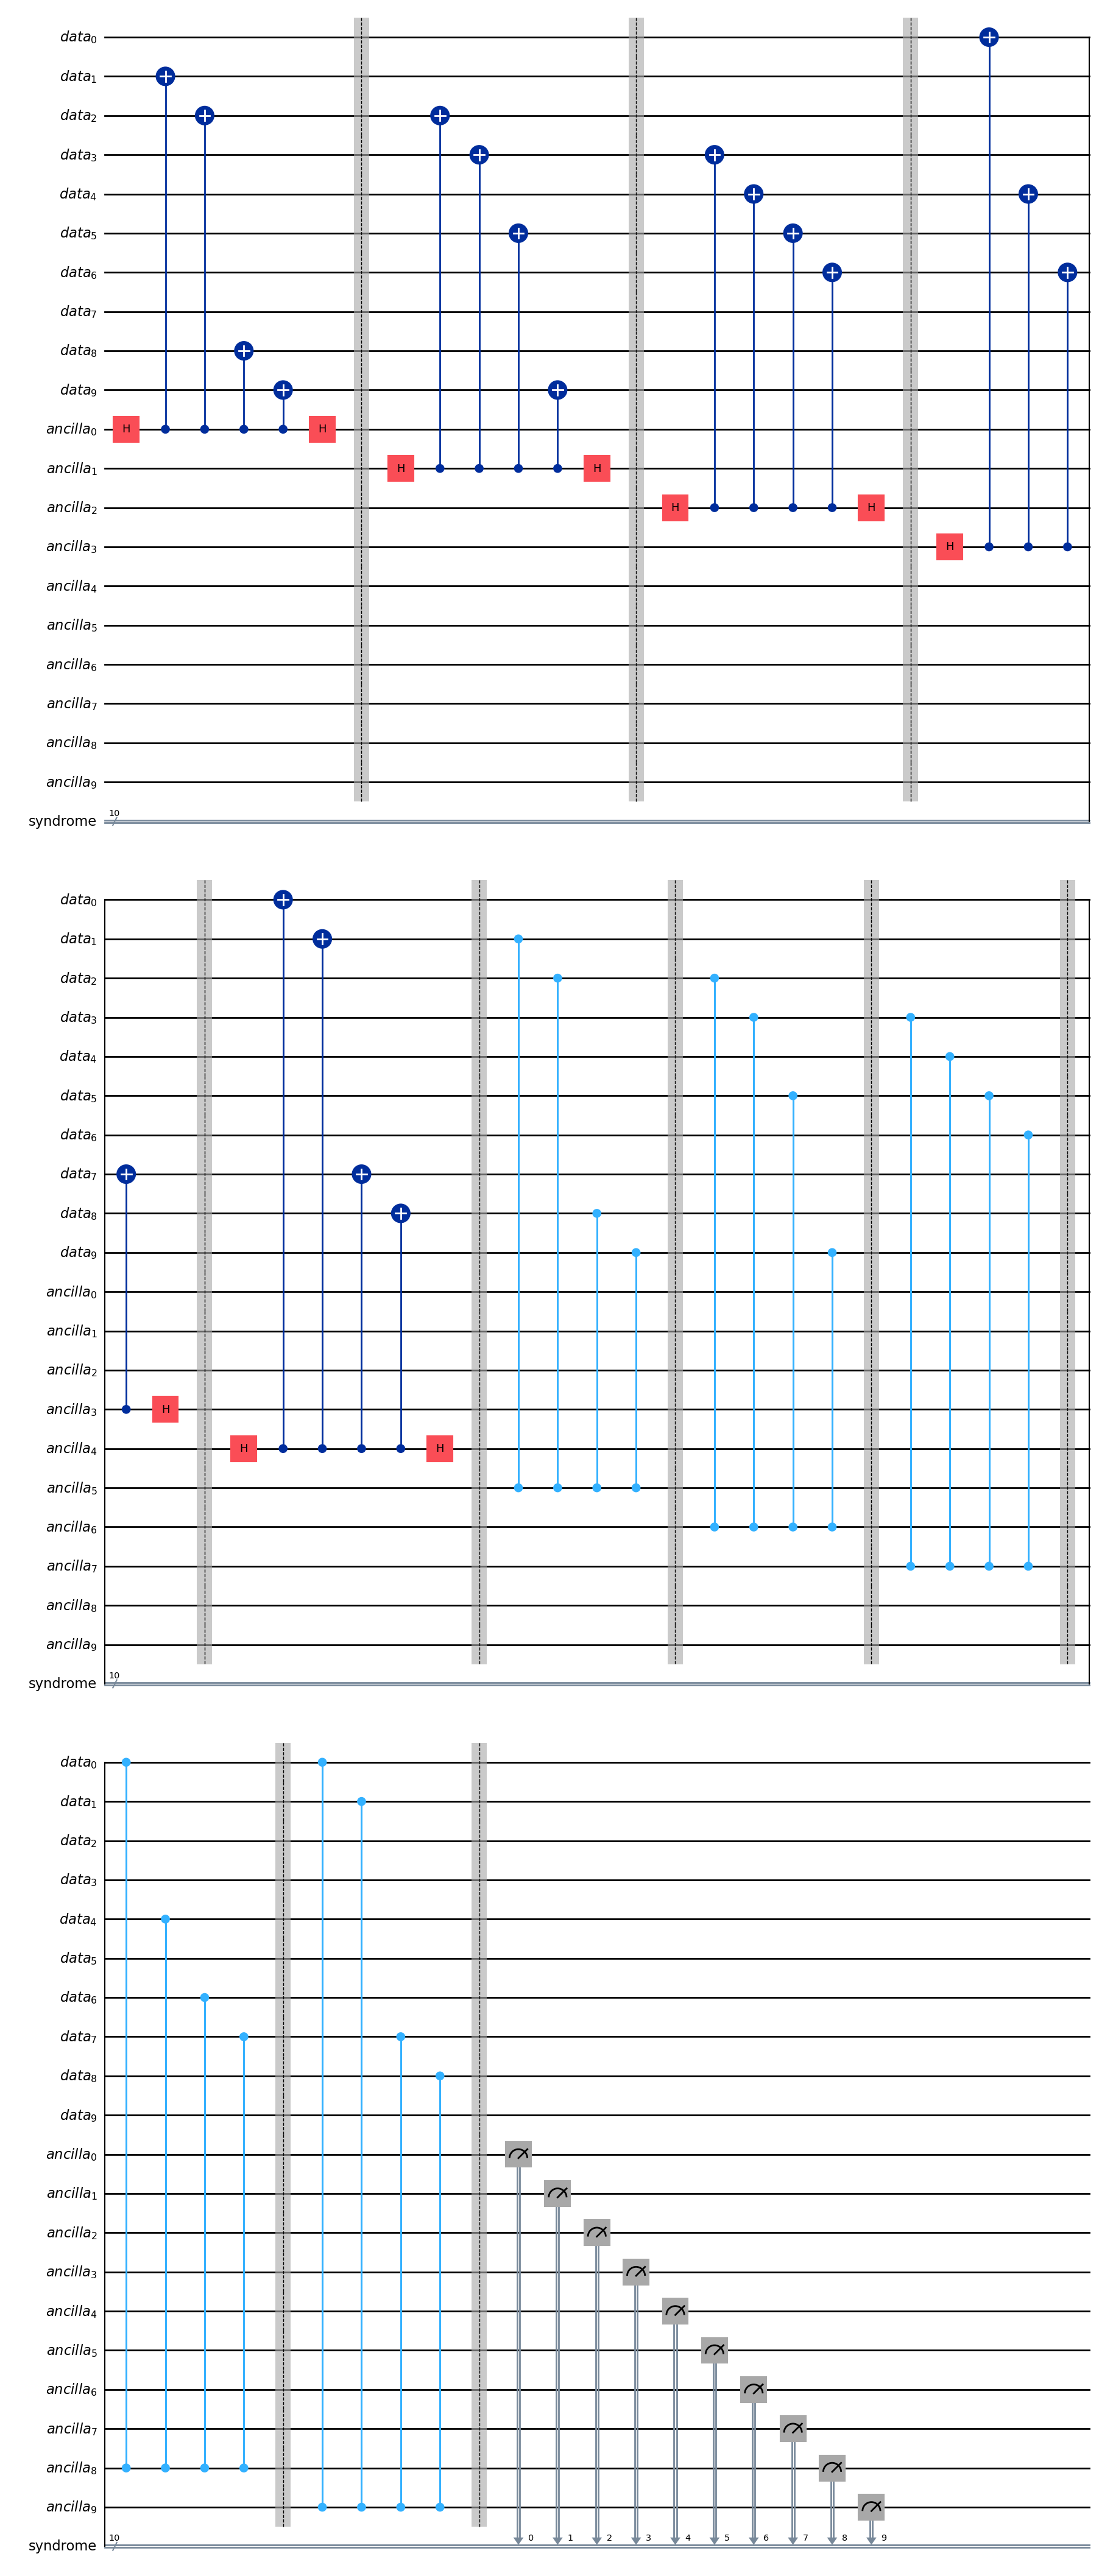

In [45]:
def build_stabilizer_circuit(Hx, Hz):
    num_data_qubits = Hx.shape[1]
    num_x_stabilizers = Hx.shape[0]
    num_z_stabilizers = Hz.shape[0]
    num_ancilla_qubits = num_x_stabilizers + num_z_stabilizers

    # Create quantum and classical registers
    data = QuantumRegister(num_data_qubits, 'data')
    ancilla = QuantumRegister(num_ancilla_qubits, 'ancilla')
    classical_bits = ClassicalRegister(num_ancilla_qubits, 'syndrome')

    qc = QuantumCircuit(data, ancilla, classical_bits)

    # Measure X stabilizers
    for i in range(num_x_stabilizers):
        qc.h(ancilla[i])  # Prepare ancilla in superposition
        for j in range(num_data_qubits):
            if Hx[i, j]:
                qc.cx(ancilla[i], data[j])
        qc.h(ancilla[i])  # Hadamard to convert back
        qc.barrier()

    # Measure Z stabilizers
    for i in range(num_z_stabilizers):
        idx = i + num_x_stabilizers  # Offset for ancilla qubits
        for j in range(num_data_qubits):
            if Hz[i, j]:
                qc.cz(ancilla[idx], data[j])
        qc.barrier()

    # Measure ancilla qubits
    qc.measure(ancilla, classical_bits)
    return qc, data, ancilla

# Build the circuit
qc, data, ancilla = build_stabilizer_circuit(Hx, Hz)
qc.draw('mpl')


In [46]:
def introduce_pauli_errors(qc, data_qubits, error_prob):
    """
    Introduce random Pauli errors on data qubits with a given probability.
    """
    import numpy as np  # Ensure numpy is imported
    for qubit in data_qubits:
        r = np.random.rand()
        if r < error_prob:
            error_type = np.random.choice(['x', 'y', 'z'])
            if error_type == 'x':
                qc.x(qubit)
            elif error_type == 'y':
                qc.y(qubit)
            elif error_type == 'z':
                qc.z(qubit)

In [48]:
# Introduce errors on data qubits
error_prob = 0.01  # Set your desired error probability
introduce_pauli_errors(qc, data, error_prob)

In [49]:
# Simulate the circuit
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)
result = simulator.run(compiled_circuit, noise_model=noise_model, shots=1024).result()
counts = result.get_counts()
print("Measurement results:")
print(counts)


Measurement results:
{'0010011110': 1, '0010011010': 1, '0010010010': 2, '0110011110': 1, '0100001010': 1, '0001001010': 2, '1000001001': 2, '0100010001': 1, '1000011011': 1, '0010011000': 2, '1000000110': 1, '0010010100': 1, '1000000101': 1, '0100010100': 1, '0000000100': 5, '1000010111': 2, '0100000101': 1, '0001010010': 1, '1000011110': 1, '0100000000': 1, '0100001100': 2, '0000001101': 8, '0000011100': 2, '0001011101': 1, '0001010100': 2, '0001000101': 1, '0000001111': 62, '0000110101': 1, '0100011101': 1, '0000000011': 55, '0001001100': 1, '0001001001': 1, '0000010011': 5, '0000001110': 3, '0010000110': 1, '0001001111': 2, '1000001010': 1, '0000100110': 1, '0000010000': 5, '0000011001': 7, '1000010010': 1, '0000100010': 1, '0010001100': 3, '0000100011': 1, '0100011011': 1, '0000110011': 1, '0010010111': 1, '0000011110': 48, '0000011011': 80, '0000001001': 55, '0000001011': 3, '0001011011': 1, '0000110001': 2, '0000000000': 47, '0000000101': 53, '0000011101': 55, '1000011001': 1, '

In [50]:
# Initialize the decoder
bp_osd = BpOsdDecoder(
    H0,
    error_rate=error_prob,
    bp_method='product_sum',
    max_iter=15,
    schedule='serial',
    osd_method='osd_cs',
    osd_order=2
)

In [51]:
print("\nDecoding Syndromes:")
for outcome, frequency in counts.items():
    syndrome_str = outcome[::-1]  # Reverse bitstring if necessary
    syndrome = np.array([int(bit) for bit in syndrome_str], dtype=int)
    decoding = bp_osd.decode(syndrome)
    # For brevity, we can display the positions where errors are detected
    error_positions = np.where(decoding == 1)[0]
    print(f"Syndrome: {syndrome_str}, Frequency: {frequency}, Error positions: {error_positions}")



Decoding Syndromes:
Syndrome: 0111100100, Frequency: 1, Error positions: [ 6  9 10]
Syndrome: 0101100100, Frequency: 1, Error positions: [ 4  6 15]
Syndrome: 0100100100, Frequency: 2, Error positions: [3 7]
Syndrome: 0111100110, Frequency: 1, Error positions: [ 6  9 10]
Syndrome: 0101000010, Frequency: 1, Error positions: [0 4]
Syndrome: 0101001000, Frequency: 2, Error positions: [4 5]
Syndrome: 1001000001, Frequency: 2, Error positions: [1 2]
Syndrome: 1000100010, Frequency: 1, Error positions: [ 7 11]
Syndrome: 1101100001, Frequency: 1, Error positions: [1 3]
Syndrome: 0001100100, Frequency: 2, Error positions: [ 6 10]
Syndrome: 0110000001, Frequency: 1, Error positions: [9]
Syndrome: 0010100100, Frequency: 1, Error positions: [0 6]
Syndrome: 1010000001, Frequency: 1, Error positions: [4 8]
Syndrome: 0010100010, Frequency: 1, Error positions: [0 1]
Syndrome: 0010000000, Frequency: 5, Error positions: []
Syndrome: 1110100001, Frequency: 2, Error positions: [2 4]
Syndrome: 1010000010,